In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from tqdm import tqdm

import os
import sys

from scipy.optimize import minimize
# code to manage where are lunch the file
if str(os.getcwd()).split("/")[-1] == "notebooks":
    sys.path.insert(1, os.path.realpath(os.path.pardir))
    path_b = "../"
else:
    path_b ='./'
import config as c

In [2]:
windows = c.windows
number_crypto = c.number_cryptos
market_cap = c.market_cap

df_name_index = pd.read_csv(f"{path_b}data/processed/first_{number_crypto}_crypto_list.csv", index_col=0)
df = pd.read_csv(f"{path_b}data/processed/market_cap_crypto.csv", index_col=0)

df_close_price = pd.read_csv(f'{path_b}data/processed/close_price_crypto.csv', index_col=0)
df_close_price['date'] = pd.to_datetime(df_close_price.index)
df_close_price['date'] = df_close_price['date'].dt.date
df_close_price.index = df_close_price['date']
del df_close_price['date']

In [3]:
## use market cap file

df_market_cap = pd.read_csv(f'{path_b}data/processed/crypto_date_marketcap_sorted.csv', index_col=0)


df_market_cap_first_20 = df_market_cap.iloc[:number_crypto]

#select last date
first_date = df_market_cap_first_20['first_date_marketcap'].tail(1).values

first_date_final = pd.to_datetime(first_date[0])

df_final_data = df_close_price.drop(df_close_price[df_close_price.index < first_date_final].index)
df_final_data = df_final_data[df_market_cap_first_20['crypto_name']]
df_final_data_return = np.log(df_final_data/df_final_data.shift(1)).dropna()


/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [4]:
def Min_variance(alloc, return_cov_matrix):
    matrix_one = np.ones(len(return_cov_matrix))
    criterion = 0.5*np.dot(np.transpose(alloc).dot(return_cov_matrix),alloc)
    return criterion

def optimizer(cov_matrix_test):
    length = len(cov_matrix_test)

    x0 = np.zeros(length) + 0.001

    Bounds= [(0 , 1) for i in range(0,length)] #Long only positions
    cons=({'type':'eq', 'fun': lambda x:sum(x)-1}) #Sum of weights is equal to 1


    #Optimisation
    res_MIN_VAR = minimize(Min_variance, x0, method='SLSQP', args=(cov_matrix_test),bounds=Bounds,constraints=cons,options={'disp': False})
    return res_MIN_VAR.x


length_index = df_final_data_return.shape[0]

weights_min_var = []
for i in tqdm(range(length_index-windows)):
    cov_matrix = df_final_data_return.iloc[i:windows+i].cov()
    weight = optimizer(cov_matrix.values)
    weights_min_var.append(weight)

labels = df_final_data_return.columns

df_results_min_var = pd.DataFrame(weights_min_var)
df_results_min_var.columns = labels
#df_results_min_var.index = df_final_data_return.iloc[windows:].index

100%|██████████| 871/871 [00:19<00:00, 43.72it/s] 


In [5]:
df_results_min_var.tail(10)

,bitcoin,litecoin,ripple,dogecoin,dash,stellar,nem,ethereum,ethereum-classic,neo,iota,eos,bitcoin-cash,binance-coin,tron,chainlink,cardano,theta,vechain,wrapped-bitcoin
861,0.288599,0.034492,1.843144e-18,4.336809e-19,1.734723e-18,0.000000e+00,0.000000e+00,0.082070,0.000000e+00,4.336809e-19,0.000000e+00,0.000000e+00,0.106463,0.086577,2.316365e-02,7.589415e-18,0.088427,0.000000e+00,0.000000e+00,0.290208
862,0.327915,0.003661,1.734723e-18,0.000000e+00,3.989864e-17,1.431147e-17,1.734723e-18,0.071091,2.602085e-18,0.000000e+00,0.000000e+00,3.252607e-19,0.103093,0.081023,1.734723e-17,1.301043e-17,0.083343,0.000000e+00,0.000000e+00,0.329874
863,0.279864,0.032434,0.000000e+00,2.331035e-18,6.071532e-17,7.377996e-17,0.000000e+00,0.089203,0.000000e+00,9.053088e-18,0.000000e+00,0.000000e+00,0.107624,0.089604,2.396458e-02,0.000000e+00,0.095947,8.294147e-18,2.081668e-17,0.281358
864,0.323538,0.008874,0.000000e+00,1.647987e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.074409,0.000000e+00,3.903128e-18,0.000000e+00,0.000000e+00,0.100477,0.080709,1.387779e-17,0.000000e+00,0.086755,1.908196e-17,1.821460e-17,0.325238
865,0.326838,0.007998,0.000000e+00,4.336809e-18,4.185020e-17,1.843144e-17,0.000000e+00,0.071416,2.168404e-19,3.469447e-18,0.000000e+00,6.830474e-18,0.098583,0.081883,1.387779e-17,6.667843e-18,0.086701,1.214306e-17,4.336809e-18,0.326580
866,0.286964,0.033439,0.000000e+00,1.734723e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.083595,0.000000e+00,0.000000e+00,2.168404e-18,7.372575e-18,0.103515,0.094146,1.999213e-02,7.806256e-18,0.090996,0.000000e+00,0.000000e+00,0.287352
867,0.289495,0.032800,1.301043e-17,8.294147e-18,0.000000e+00,0.000000e+00,7.155734e-18,0.082732,1.154675e-17,6.722053e-18,5.637851e-18,1.431147e-17,0.104819,0.090725,1.913805e-02,0.000000e+00,0.090414,1.149254e-17,2.710505e-17,0.289877
868,0.287136,0.032990,0.000000e+00,1.040834e-17,3.122502e-17,5.421011e-18,0.000000e+00,0.086409,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.105554,0.091564,1.816236e-02,0.000000e+00,0.090354,0.000000e+00,0.000000e+00,0.287830
869,0.283170,0.031931,3.144186e-18,3.035766e-18,1.734723e-17,0.000000e+00,4.282599e-18,0.088218,1.170938e-17,4.119968e-18,2.602085e-18,0.000000e+00,0.104617,0.094871,2.128966e-02,0.000000e+00,0.091819,8.673617e-18,7.372575e-18,0.284084
870,0.283442,0.033897,3.426079e-17,0.000000e+00,0.000000e+00,0.000000e+00,2.515349e-17,0.089471,2.862294e-17,0.000000e+00,2.341877e-17,3.556183e-17,0.105381,0.092111,2.211143e-02,3.903128e-18,0.089414,0.000000e+00,0.000000e+00,0.284173


Text(0.5, 1.0, 'Min Variance')

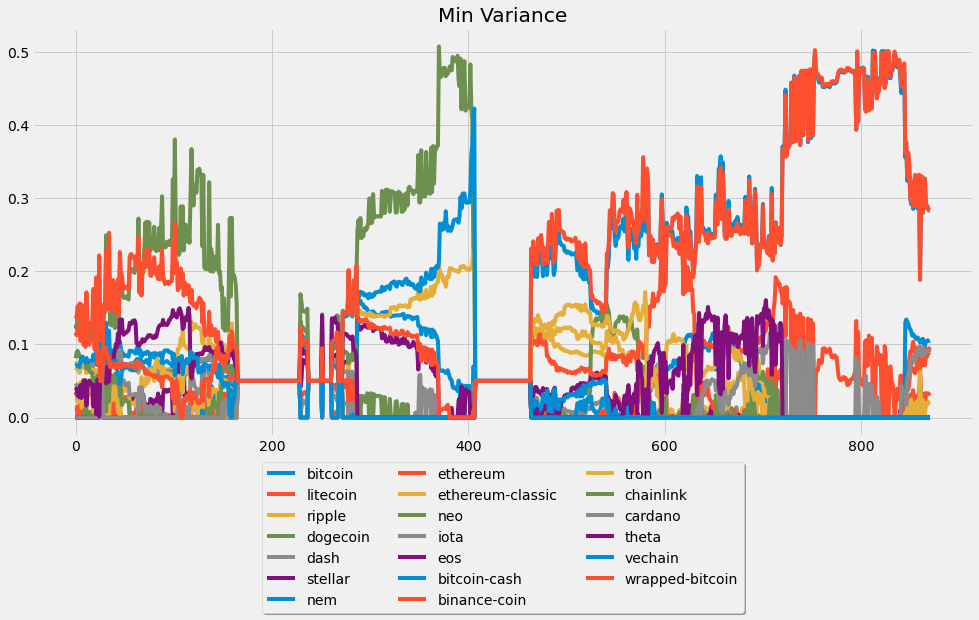

In [6]:
# TODO: mettre une color pour chaque line (http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html)
plt.figure(figsize=(15,7))
plt.plot(df_results_min_var)
plt.legend(df_results_min_var.columns, loc="lower center", fancybox=True, shadow=True,ncol=3,bbox_to_anchor=(0.5, -0.45))
plt.title("Min Variance")

In [7]:
portfolio_min_var = np.sum(np.multiply(df_final_data_return.iloc[windows:], df_results_min_var),1)

<ipython-input-7-428fa6e69948>:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  portfolio_min_var = np.sum(np.multiply(df_final_data_return.iloc[windows:], df_results_min_var),1)


In [8]:
#bug avec ces deux dates
portfolio_min_var = portfolio_min_var.drop(portfolio_min_var[portfolio_min_var.index == pd.to_datetime("2018-05-09") ].index)
portfolio_min_var = portfolio_min_var.drop(portfolio_min_var[portfolio_min_var.index == pd.to_datetime("2018-05-10") ].index)
portfolio_min_var

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


date
2019-05-31    0.032698
2019-06-01   -0.006347
2019-06-02    0.020992
2019-06-03   -0.066972
2019-06-04   -0.051162
                ...   
2021-10-13    0.027689
2021-10-14    0.004209
2021-10-15    0.050999
2021-10-16   -0.010630
2021-10-17    0.004742
Length: 871, dtype: float64

In [11]:
# TODO: debug end of the performance graph
plt.figure(figsize=(15,7))
plt.plot((portfolio_min_var+1).cumprod()*100)
plt.legend(['Min Var'],loc='upper left',fontsize='large',fancybox=True, shadow=True)
plt.title('Performance of Min-Var portfolio')
plt.show()

MV = (portfolio_min_var+1).cumprod()*100
MV.to_csv(f"../data/processed/MV_{number_crypto}_price.csv")

SyntaxError: EOL while scanning string literal (<ipython-input-11-ed7b96f9bba4>, line 9)

In [10]:
portfolio_min_var.drop(portfolio_min_var[portfolio_min_var.index < pd.to_datetime("2018-05-06") ].index)

date
2019-05-31    0.032698
2019-06-01   -0.006347
2019-06-02    0.020992
2019-06-03   -0.066972
2019-06-04   -0.051162
                ...   
2021-10-13    0.027689
2021-10-14    0.004209
2021-10-15    0.050999
2021-10-16   -0.010630
2021-10-17    0.004742
Length: 871, dtype: float64